# Purchases Marketing Analytics

## Exporlatory Analysis

In [1]:
# Load text file into local variable called 'data'
data = read.delim(file = 'D:/Data/purchases.txt', header = FALSE, sep = '\t', dec = '.')

In [2]:
# Add headers and interpret the last column as a date, extract year of purchase
colnames(data) = c('customer_id', 'purchase_amount', 'date_of_purchase')
data$date_of_purchase = as.Date(data$date_of_purchase, "%Y-%m-%d")
data$year_of_purchase = as.numeric(format(data$date_of_purchase, "%Y"))
data$days_since       = as.numeric(difftime(time1 = "2016-01-01",
                                            time2 = data$date_of_purchase,
                                            units = "days"))

In [3]:
# Display the data after transformation
head(data)
summary(data)

,customer_id,purchase_amount,date_of_purchase,year_of_purchase,days_since
1,760,25,2009-11-06,2009,2247.25
2,860,50,2012-09-28,2012,1190.25
3,1200,100,2005-10-25,2005,3720.25
4,1420,50,2009-07-09,2009,2367.25
5,1940,70,2013-01-25,2013,1071.25
6,1960,40,2013-10-29,2013,794.25


  customer_id     purchase_amount   date_of_purchase     year_of_purchase
 Min.   :    10   Min.   :   5.00   Min.   :2005-01-02   Min.   :2005    
 1st Qu.: 57720   1st Qu.:  25.00   1st Qu.:2009-01-17   1st Qu.:2009    
 Median :102440   Median :  30.00   Median :2011-11-23   Median :2011    
 Mean   :108935   Mean   :  62.34   Mean   :2011-07-14   Mean   :2011    
 3rd Qu.:160525   3rd Qu.:  60.00   3rd Qu.:2013-12-29   3rd Qu.:2013    
 Max.   :264200   Max.   :4500.00   Max.   :2015-12-31   Max.   :2015    
   days_since     
 Min.   :   1.25  
 1st Qu.: 733.25  
 Median :1500.25  
 Mean   :1632.19  
 3rd Qu.:2540.25  
 Max.   :4016.25  

## Compute key marketing indicators using SQL language

In [4]:
library(sqldf)

Warning message:
: package 'sqldf' was built under R version 3.2.2Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Loading required package: DBI


In [5]:
# Compute RFM variables as of a year ago
customers_2014 = sqldf("SELECT customer_id,
                               MIN(days_since) - 365 AS 'recency',
                               MAX(days_since) - 365 AS 'first_purchase',
                               COUNT(*) AS 'frequency',
                               AVG(purchase_amount) AS 'avg_amount',
                               MAX(purchase_amount) AS 'max_amount'
                        FROM data
                        WHERE days_since > 365
                        GROUP BY 1")

# Compute revenues generated by customers in 2015
revenue_2015 = sqldf("SELECT customer_id, SUM(purchase_amount) AS 'revenue_2015'
                      FROM data
                      WHERE year_of_purchase = 2015
                      GROUP BY 1")


# Merge 2015 customers and 2015 revenue
in_sample = merge(customers_2014, revenue_2015, all.x = TRUE)
in_sample$revenue_2015[is.na(in_sample$revenue_2015)] = 0
in_sample$active_2015 = as.numeric(in_sample$revenue_2015 > 0)

Loading required package: tcltk


### Explore the Data

In [6]:
# Display calibration (in-sample) data
head(in_sample)
summary(in_sample)

,customer_id,recency,first_purchase,frequency,avg_amount,max_amount,revenue_2015,active_2015
1,10,3464.25,3464.25,1,30,30,0,0
2,80,302.25,3386.25,6,70,80,80,1
3,90,393.25,3418.25,10,115.8,153,0,0
4,120,1036.25,1036.25,1,20,20,0,0
5,130,2605.25,3345.25,2,50,60,0,0
6,160,2598.25,3212.25,2,30,30,0,0


  customer_id        recency        first_purchase      frequency     
 Min.   :    10   Min.   :   1.25   Min.   :   1.25   Min.   : 1.000  
 1st Qu.: 77710   1st Qu.: 258.25   1st Qu.: 796.25   1st Qu.: 1.000  
 Median :127140   Median : 890.25   Median :1891.25   Median : 2.000  
 Mean   :127315   Mean   :1122.84   Mean   :1788.66   Mean   : 2.665  
 3rd Qu.:181800   3rd Qu.:1868.25   3rd Qu.:2695.25   3rd Qu.: 3.000  
 Max.   :245840   Max.   :3649.25   Max.   :3651.25   Max.   :40.000  
   avg_amount        max_amount       revenue_2015      active_2015    
 Min.   :   5.00   Min.   :   5.00   Min.   :   0.00   Min.   :0.0000  
 1st Qu.:  21.25   1st Qu.:  25.00   1st Qu.:   0.00   1st Qu.:0.0000  
 Median :  30.00   Median :  30.00   Median :   0.00   Median :0.0000  
 Mean   :  55.53   Mean   :  65.72   Mean   :  21.22   Mean   :0.2299  
 3rd Qu.:  50.00   3rd Qu.:  60.00   3rd Qu.:   0.00   3rd Qu.:0.0000  
 Max.   :4500.00   Max.   :4500.00   Max.   :4500.00   Max.   :1.0000  

## Calibrate the Models

In [22]:
library(nnet)
prob.model = multinom(formula = active_2015 ~ recency + log(recency) + frequency + log(frequency),
                      data = in_sample)
coef = summary(prob.model)$coefficients
std  = summary(prob.model)$standard.errors






# weights:  6 (5 variable)
initial  value 11717.653087 
iter  10 value 6026.607151
final  value 6022.011633 
converged


In [23]:
print(coef)

   (Intercept)        recency   log(recency)      frequency log(frequency) 
   0.372776856   -0.001320808   -0.234921694   -0.013786966    0.877395298 


In [24]:
print(std)

   (Intercept)        recency   log(recency)      frequency log(frequency) 
  8.698366e-02   6.430374e-05   1.871025e-02   1.886430e-02   7.210808e-02 


In [25]:
#To determine statistical significance  look for -2 to + 2
print(coef / std)


   (Intercept)        recency   log(recency)      frequency log(frequency) 
     4.2855963    -20.5401408    -12.5557724     -0.7308496     12.1677798 


### Calibrate Monetary Model

Only use active customers from 2015

In [26]:
# For the monetary model, select only those who made a purchase
z = which(in_sample$active_2015 == 1)
head(in_sample[z, ])
summary(in_sample[z, ])

,customer_id,recency,first_purchase,frequency,avg_amount,max_amount,revenue_2015,active_2015
2,80,302.25,3386.25,6,70,80,80,1
18,480,16.25,3313.25,11,62.27273,235,45,1
30,830,267.25,3374.25,6,48.33333,60,50,1
31,850,62.25,3051.25,8,28.125,30,60,1
32,860,267.25,3643.25,9,53.33333,60,60,1
39,1020,1462.25,1827.25,3,73.33333,100,120,1


  customer_id        recency        first_purchase      frequency     
 Min.   :    80   Min.   :   1.25   Min.   :   1.25   Min.   : 1.000  
 1st Qu.: 78590   1st Qu.:  23.25   1st Qu.: 650.00   1st Qu.: 2.000  
 Median :143550   Median :  97.25   Median :1604.25   Median : 4.000  
 Mean   :134907   Mean   : 306.60   Mean   :1636.41   Mean   : 4.741  
 3rd Qu.:194363   3rd Qu.: 328.25   3rd Qu.:2666.25   3rd Qu.: 7.000  
 Max.   :236660   Max.   :3544.25   Max.   :3647.25   Max.   :40.000  
   avg_amount        max_amount       revenue_2015     active_2015
 Min.   :   5.00   Min.   :   5.00   Min.   :   5.0   Min.   :1   
 1st Qu.:  30.00   1st Qu.:  30.00   1st Qu.:  30.0   1st Qu.:1   
 Median :  40.00   Median :  50.00   Median :  50.0   Median :1   
 Mean   :  67.78   Mean   :  88.33   Mean   :  92.3   Mean   :1   
 3rd Qu.:  60.00   3rd Qu.:  80.00   3rd Qu.: 100.0   3rd Qu.:1   
 Max.   :4500.00   Max.   :4500.00   Max.   :4500.0   Max.   :1   

In [27]:
# Calibrate the monetary model (version 1)
amount.model = lm(formula = revenue_2015 ~ avg_amount + max_amount, data = in_sample[z, ])
summary(amount.model)


Call:
lm(formula = revenue_2015 ~ avg_amount + max_amount, data = in_sample[z, 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2138.5   -20.1   -16.6     0.1  3361.8 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 20.74709    2.38112   8.713   <2e-16 ***
avg_amount   0.67486    0.03280  20.575   <2e-16 ***
max_amount   0.29225    0.02363  12.367   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 136.6 on 3883 degrees of freedom
Multiple R-squared:  0.6054,	Adjusted R-squared:  0.6052 
F-statistic:  2979 on 2 and 3883 DF,  p-value: < 2.2e-16


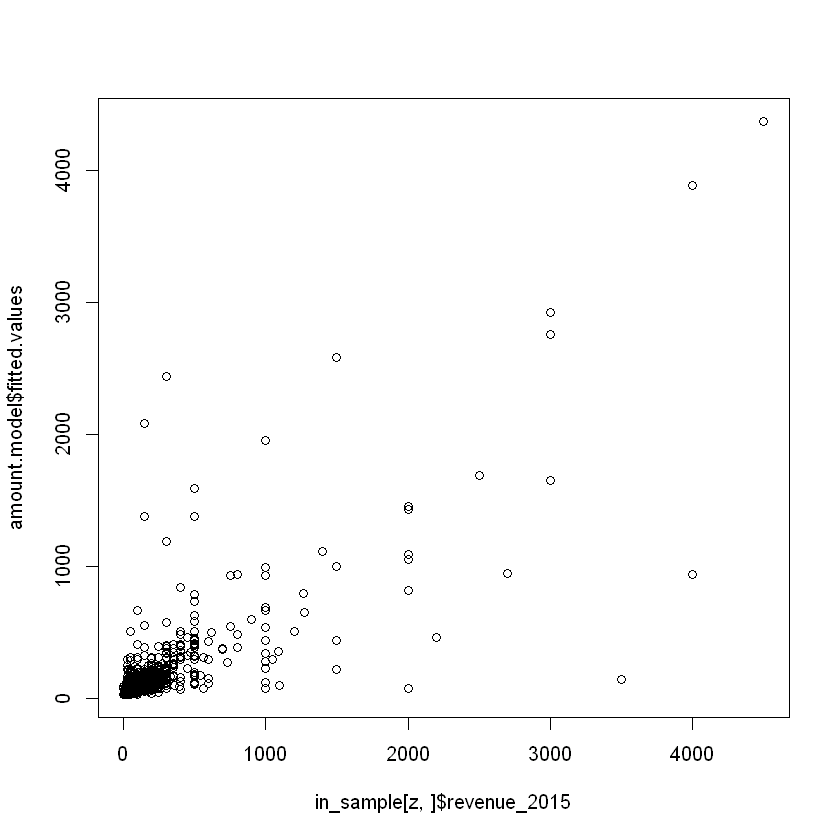

In [28]:
# Plot the results of the monetary model
plot(x = in_sample[z, ]$revenue_2015, y = amount.model$fitted.values)

In [31]:
# Re-calibrate the monetary model, using a log-transform (version 2)
#amount.model = lm(formula = log(revenue_2015) ~ log(avg_amount) + log(max_amount), data = in_sample[z, ])
#summary(amount.model)

amount.model = lm(formula = log(revenue_2015) ~ recency + log(recency) + frequency+ log(frequency), data = in_sample[z, ])
summary(amount.model)


Call:
lm(formula = log(revenue_2015) ~ recency + log(recency) + frequency + 
    log(frequency), data = in_sample[z, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4200 -0.5422 -0.1014  0.4909  4.4688 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     3.935e+00  4.454e-02  88.346  < 2e-16 ***
recency        -4.029e-06  3.637e-05  -0.111 0.911801    
log(recency)   -2.548e-02  9.198e-03  -2.770 0.005632 ** 
frequency       2.895e-02  8.352e-03   3.466 0.000533 ***
log(frequency)  2.031e-02  3.907e-02   0.520 0.603237    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8504 on 3881 degrees of freedom
Multiple R-squared:  0.0282,	Adjusted R-squared:  0.0272 
F-statistic: 28.15 on 4 and 3881 DF,  p-value: < 2.2e-16


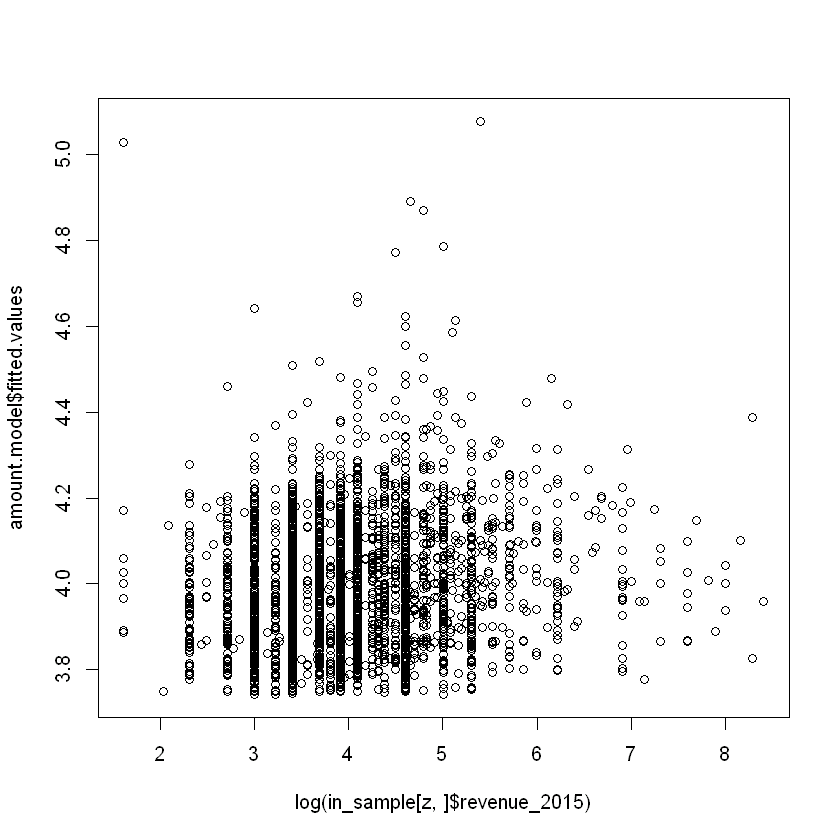

In [32]:
# Plot the results of this new monetary model
plot(x = log(in_sample[z, ]$revenue_2015), y = amount.model$fitted.values)

APPLY THE MODELS TO TODAY'S DATA

In [33]:
# Compute RFM variables as of today
customers_2015 = sqldf("SELECT customer_id,
                               MIN(days_since) AS 'recency',
                               MAX(days_since) AS 'first_purchase',
                               COUNT(*) AS 'frequency',
                               AVG(purchase_amount) AS 'avg_amount',
                               MAX(purchase_amount) AS 'max_amount'
                        FROM data GROUP BY 1")

In [34]:
# Predict the target variables based on today's data
customers_2015$prob_predicted    = predict(object = prob.model, newdata = customers_2015, type = "probs")

In [35]:
customers_2015$revenue_predicted = exp(predict(object = amount.model, newdata = customers_2015))

In [36]:
customers_2015$score_predicted   = customers_2015$prob_predicted * customers_2015$revenue_predicted

In [37]:
summary(customers_2015$prob_predicted)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.001014 0.019810 0.095990 0.225300 0.362700 0.953100 

In [38]:
summary(customers_2015$revenue_predicted)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  41.96   43.53   45.48   48.15   50.01  186.70 

In [39]:
summary(customers_2015$score_predicted)
#Mean value indicates average spending 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.04257   0.88230   4.42300  12.43000  17.99000 171.40000 

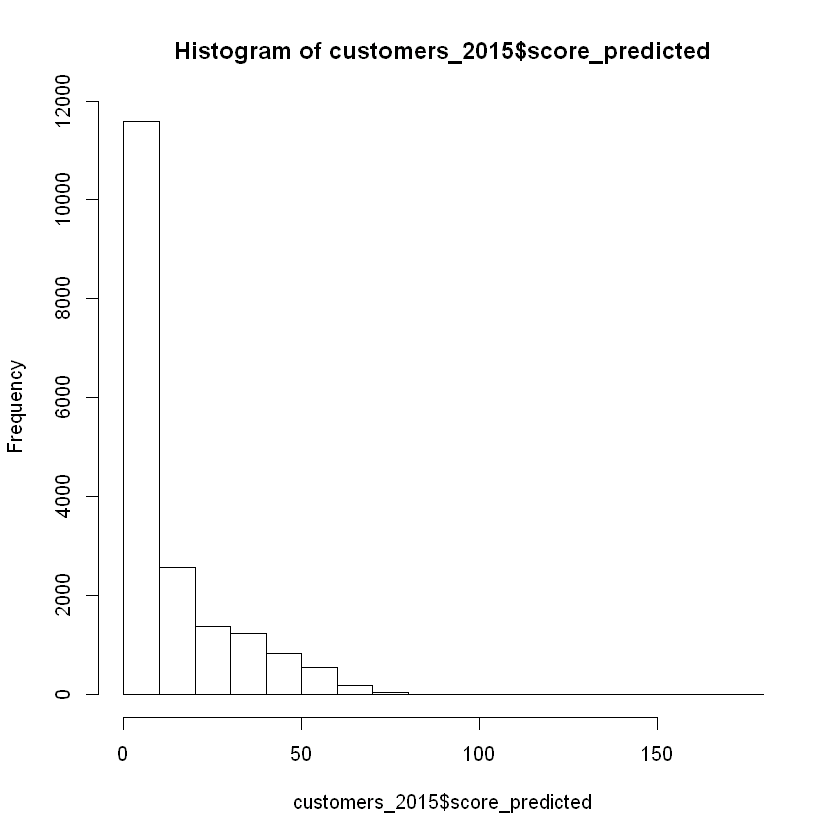

In [40]:
hist(customers_2015$score_predicted)

In [41]:
# How many customers have an expected revenue of more than $50
z = which(customers_2015$score_predicted > 50)
print(length(z))

[1] 798


In [42]:
z

[1]    18    31    39    43    46    50    52    85    88    92   102   115
 [13]   120   129   135   151   152   153   157   161   164   166   170   175
 [25]   194   204   210   216   220   224   237   250   257   259   261   267
 [37]   269   271   280   286   301   316   320   328   333   338   349   352
 [49]   373   386   398   408   422   425   428   432   434   458   459   464
 [61]   466   470   475   480   487   516   520   521   527   535   540   547
 [73]   550   558   564   571   574   595   599   603   611   635   636   642
 [85]   645   648   656   657   662   663   667   674   675   678   679   681
 [97]   683   685   691   697   702   704   706   707   714   715   717   718
[109]   719   720   724   728   732   733   734   736   739   741   744   747
[121]   757   759   760   766   767   770   773   775   781   786   793   794
[133]   801   802   803   804   821   841   843   844   845   855   859   891
[145]   911   920   927   929   942   960   961   970   976   992  1003  1008
[157]  1013  1016  1024  1027  1042  1048  1059  1107  1113  1123  1125  1131
[169]  1148  1155  1160  1166  1181  1197  1198  1205  1210  1214  1230  1231
[181]  1236  1252  1265  1266  1270  1279  1286  1296  1303  1312  1321  1332
[193]  1335  1358  1375  1387  1389  1390  1393  1402  1405  1407  1413  1435
[205]  1441  1444  1449  1450  1455  1456  1458  1464  1476  1501  1534  1537
[217]  1540  1548  1550  1551  1558  1567  1577  1598  1610  1623  1629  1652
[229]  1656  1659  1661  1668  1670  1678  1684  1689  1693  1694  1695  1697
[241]  1698  1702  1705  1721  1726  1733  1734  1741  1759  1775  1801  1807
[253]  1809  1816  1824  1853  1867  1874  1877  1928  1946  1947  1953  1955
[265]  1959  1986  1987  1990  1992  2009  2029  2045  2049  2055  2060  2069
[277]  2071  2072  2081  2092  2121  2139  2208  2228  2240  2249  2262  2264
[289]  2268  2270  2276  2278  2280  2284  2329  2354  2356  2378  2389  2391
[301]  2398  2408  2411  2420  2423  2428  2459  2463  2466  2477  2484  2487
[313]  2489  2506  2514  2528  2536  2546  2550  2555  2557  2566  2567  2569
[325]  2570  2585  2588  2590  2602  2603  2611  2613  2616  2627  2630  2636
[337]  2656  2676  2686  2697  2702  2705  2707  2714  2740  2741  2756  2767
[349]  2772  2773  2777  2780  2786  2791  2801  2805  2806  2807  2814  2872
[361]  2881  2891  2903  2925  2956  3031  3033  3064  3077  3081  3095  3105
[373]  3113  3128  3150  3216  3262  3266  3296  3317  3324  3327  3332  3335
[385]  3347  3358  3363  3378  3395  3419  3450  3453  3468  3478  3490  3492
[397]  3547  3563  3599  3622  3631  3661  3662  3682  3699  3706  3713  3769
[409]  3790  3802  3814  3815  3843  3860  3946  3947  3960  3980  4031  4087
[421]  4109  4137  4154  4158  4237  4240  4276  4302  4370  4381  4384  4411
[433]  4424  4452  4461  4467  4477  4507  4511  4536  4573  4588  4619  4626
[445]  4646  4653  4664  4665  4679  4709  4715  4716  4730  4731  4741  4840
[457]  4850  4854  4861  4868  4879  4936  4942  4957  4976  5030  5048  5055
[469]  5073  5077  5117  5141  5165  5184  5187  5225  5235  5242  5248  5249
[481]  5258  5262  5278  5290  5292  5296  5311  5318  5333  5334  5345  5354
[493]  5364  5370  5371  5376  5379  5398  5407  5412  5436  5439  5440  5447
[505]  5457  5473  5484  5543  5557  5562  5634  5668  5683  5687  5726  5744
[517]  5758  5795  5807  5809  5833  5834  5857  5858  5868  5879  5892  5894
[529]  5928  5972  6061  6070  6074  6077  6100  6142  6169  6171  6172  6203
[541]  6225  6232  6251  6253  6423  6461  6507  6515  6540  6547  6558  6583
[553]  6651  6678  6703  6713  6725  6753  6756  6773  6786  6793  6796  6858
[565]  6866  6869  6871  6910  6930  6935  6947  6979  6989  7001  7060  7093
[577]  7098  7132  7136  7156  7197  7202  7246  7250  7255  7262  7264  7279
[589]  7301  7325  7327  7350  7388  7426  7461  7495  7500  7515  7522  7531
[601]  7534  7553  7557  7602  7651  7658  7671  7673  7677  7702  7772  7782
[613]  7789  7811  7869 

To validate Module 3 and correctly answer the questions will require that you perform the following exercise first: 

take the code in the file named module3.R, and modify the probability model such as the predictors taken into account exclusively include (1) recency, (2) the log of recency, (3) frequency, (4) the log of frequency. 

Also, list the detailed predictions made for the first 10 customers.